In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from scipy.interpolate import make_interp_spline
from scipy.stats import kde

import warnings

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [2]:
folder_path = os.getcwd() + '/results' # Specify the folder containing the CSV files
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')] # Get a list of all CSV files in the folder
dataframes = [] # Initialize an empty list to store DataFrames

# Loop through the CSV files and read them into DataFrames
for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    new_df = pd.read_csv(file_path)
    dataframes.append(new_df)
# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

# remove the last 2500 rows
df = df[:-2500]

df

,Unnamed: 0,seed,n_exp,n_sim,num_weeks,num_agents,capacity,threshold,contagious_threshold,contagious_duration,...,contagious_thresholdNotPresent,num_contagious_agents,contagiousness,capacity_pct,mean_attendance,mean_contagious,mean_present_contagious,std_attendance,std_contagious,std_present_contagious
0,0,65510305,sett24_7,0,4,3000,3000,0.25,0.60,1,...,0.45,600,0.38,1.0,300.000000,0.000000,0.000000,123.339639,0.000000,0.000000
1,1,71187608,sett24_7,1,11,2000,2000,0.35,0.55,10,...,0.15,400,0.22,1.0,718.000000,333.333333,23.000000,20.704267,149.071198,23.137272
2,2,88846138,sett24_7,2,8,1000,500,0.30,0.90,7,...,0.25,200,0.24,0.5,31.000000,150.000000,8.500000,13.095801,86.602540,5.678908
3,3,68193598,sett24_7,3,4,3000,1500,0.60,0.45,1,...,0.75,600,0.02,0.5,779.333333,0.000000,0.000000,345.109000,0.000000,0.000000
4,4,22753209,sett24_7,4,10,1500,1500,0.20,0.95,9,...,0.15,300,0.12,1.0,3.800000,240.000000,0.800000,1.833030,120.000000,0.748331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,995,86684920,sett24_2,995,7,1500,750,0.10,0.95,6,...,0.70,300,0.28,0.5,1.250000,225.000000,0.000000,1.639360,129.903811,0.000000
99996,996,53886616,sett24_2,996,13,1000,1000,0.60,0.05,8,...,0.80,200,0.12,1.0,503.285714,442.714286,227.857143,16.104252,398.924882,208.390724
99997,997,78002278,sett24_2,997,5,3500,1750,0.65,0.25,3,...,0.95,700,0.14,0.5,1342.333333,1427.333333,519.333333,179.874648,1048.955142,375.326821
99998,998,63831095,sett24_2,998,11,3000,1500,0.45,0.10,10,...,0.05,600,0.20,0.5,421.833333,500.000000,30.833333,48.762748,223.606798,68.945429


In [3]:
# create new necessay columns

df['inf_last'] = [0 if df.num_weeks.iloc[_] < 200 else 1 for _ in range(len(df.mean_present_contagious))]

In [4]:
dict_variables = {
    'threshold': '$t_a$',
    'contagious_threshold': '$t_i$',
    'contagious_duration': '$d_i$',
    'people_memory_weight': '$m$',
    'contagious_thresholdNotPresent': '$t_p$',
    'SIR_AgentsRecoveryTime': '$t_r$',
    'contagiousness': '$c$',
    'num_agents': '$n$',
    'capacity_pct': '$c_p$'
}

## Preliminary analysis

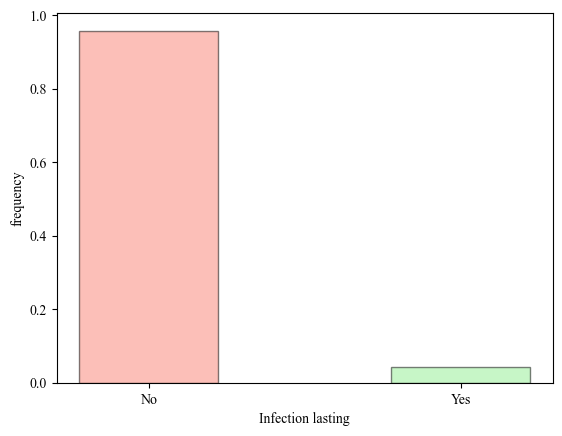

In [5]:
# create an histogram with inf_last 0 or 1
inf_last_label = ['Yes' if df.inf_last.iloc[_] == 1 else 'No' for _ in range(len(df))]
# fai l'istogramma con le percentuali
# calcola la percentuale di 0 e 1
percentages = [inf_last_label.count('No')/len(inf_last_label), inf_last_label.count('Yes')/len(inf_last_label)]
plt.bar([0.05], percentages[0], width=0.4, color='salmon', edgecolor='black', linewidth=1, alpha = 0.5)
plt.bar([0.95], percentages[1], width=0.4, color='lightgreen', edgecolor='black', linewidth=1, alpha = 0.5)

# centra le etichette sui valori
plt.xticks([0.05, 0.95], ['No', 'Yes'])
plt.xlabel('Infection lasting')
plt.ylabel('frequency')
#plt.title('Histogram of Infection Lasting')

plt.show()

In [6]:
# study parameter difference for infection and not infection

pars = ['threshold', 'contagious_threshold', 'contagious_duration', 'people_memory_weight','contagious_thresholdNotPresent', 'SIR_AgentsRecoveryTime', 'contagiousness', 'capacity_pct']
dict_pars_diff = {'pars':[], 'mean_inf':[], 'mean_no_inf':[], 'diff_pct':[]}

for p in pars:
    df_inf = df[df.inf_last == 1]
    df_no_inf = df[df.inf_last == 0]

    pct_diff = (np.mean(df_inf[p]) - np.mean(df_no_inf[p])) / np.mean(df[p])
    #print(f'The difference between the mean of {p} for infected and not infected is {100 * pct_diff:.2f} %')

    dict_pars_diff['pars'].append(p)
    dict_pars_diff['mean_inf'].append(np.mean(df_inf[p]))
    dict_pars_diff['mean_no_inf'].append(np.mean(df_no_inf[p]))
    dict_pars_diff['diff_pct'].append(pct_diff)

    if True == False:
        plt.hist(df_no_inf[p], color = 'lime', alpha = 0.5, label = 'not infected')
        plt.hist(df_inf[p], color = 'salmon', label = 'infected')
        plt.title(p)
        plt.legend()
        plt.show()

print(len(df_inf), len(df_no_inf))
df_pars_diff = pd.DataFrame(dict_pars_diff)
df_pars_diff



4160 95840


,pars,mean_inf,mean_no_inf,diff_pct
0,threshold,0.584700,0.496068,0.177349
1,contagious_threshold,0.172019,0.514284,-0.684467
2,contagious_duration,6.909615,5.444126,0.266206
3,people_memory_weight,0.390529,0.503800,-0.226956
4,contagious_thresholdNotPresent,0.563762,0.496896,0.133817
5,SIR_AgentsRecoveryTime,4.198077,5.042727,-0.168674
6,contagiousness,0.319966,0.256932,0.242855
7,capacity_pct,0.765865,0.749864,0.021320


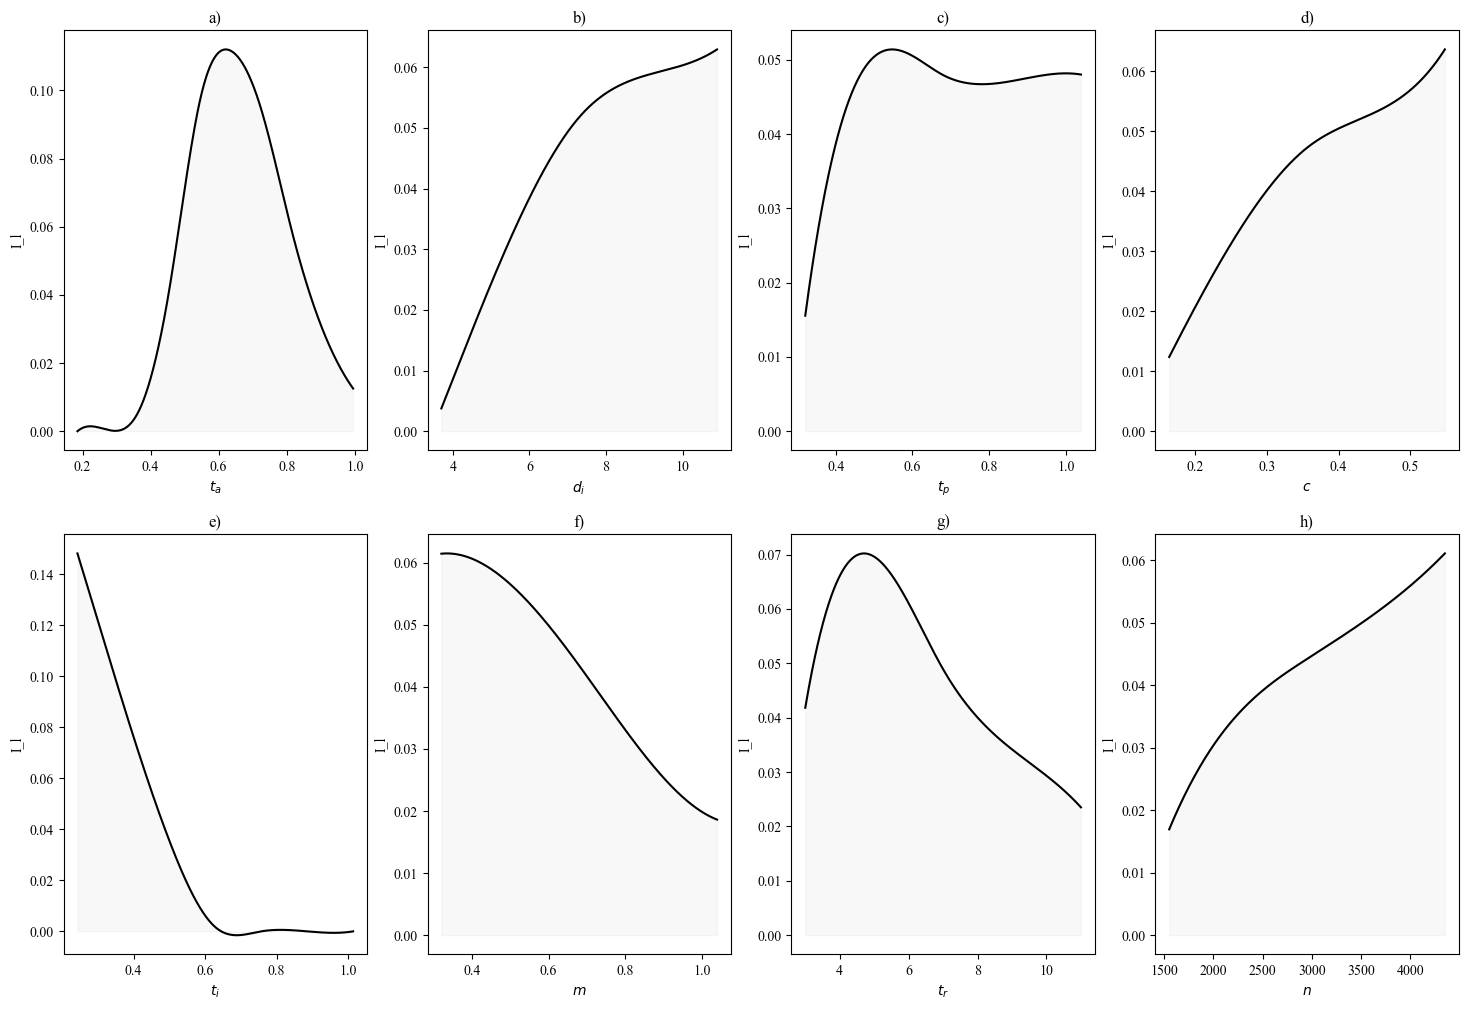

In [7]:
def get_freq(x_name, y_name, n_cat, ax):
    x, y = df[x_name], df[y_name]
    x_max, x_min = x.max(), x.min()
    
    x_step = (x_max - x_min) / n_cat
    x_range = np.arange(x_min, x_max + x_step, x_step)
    x_mean, y_mean = [], []
    for i in range(len(x_range) - 1):
        xi = x_range[i + 1]
        xi_old = x_range[i]
        df_filt = df[(df[x_name] >= xi_old) & (df[x_name] < xi)]
        y_mean.append(df_filt[y_name].mean())
        x_mean.append(xi + x_step / 2)
    plot_freq(x_mean,y_mean,x_name,y_name, ax)

def plot_freq(x_mean,y_mean,x_name,y_name, ax):
    X_Y_Spline = make_interp_spline(x_mean, y_mean)
    X_ = np.linspace(min(x_mean), max(x_mean), 500)
    Y_ = X_Y_Spline(X_)
    

    ax.plot(X_, Y_, c = 'k')
    ax.fill_between(X_, Y_, 0, alpha=0.05, color='grey')
    ax.set_xlabel(pars_symb[pars.index(x_name)])
    ax.set_ylabel('I_l')
    ax.set_title(f'{letter[pars.index(x_name)]}')
    

pars = ['threshold', 'contagious_threshold', 'contagious_duration', 'people_memory_weight','contagious_thresholdNotPresent', 'SIR_AgentsRecoveryTime', 'contagiousness', 'num_agents']
pars_symb = ['$t_a$', '$t_i$', '$d_i$', '$m$', '$t_p$', '$t_r$', '$c$', '$n$']
letter = ['a)', 'e)', 'b)', 'f)', 'c)', 'g)', 'd)', 'h)']
cat = [10,7,5,5,5,5,5,5]
fig, ax = plt.subplots(2,4, figsize=(18,12))
for i,p in enumerate(pars):
    try:
        #print(i%2, i//2)
        get_freq(p,'inf_last', cat[i],ax[i%2][i//2]) # ax[i//2][i%2]
    except:
        print(f'Error in {p}') # because capacity_pct has only two values
        pass

plt.show()


### Study the number of average infected people for surviving simulations 

In [8]:
df['pct_inf'] = df.inf_last * df.mean_attendance / df.num_agents

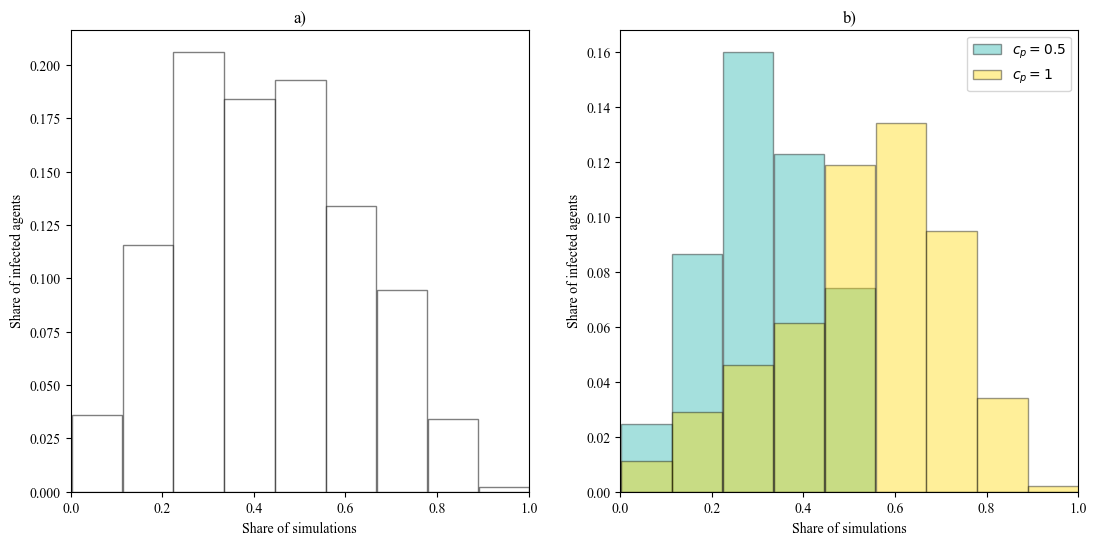

In [9]:
# turn off warning
pd.options.mode.chained_assignment = None  # default='warn'

# turn off warning for the whole code
warnings.filterwarnings("ignore")

df_inf = df[df.inf_last == 1]

x = np.linspace(0, 1, 10)
y_cap05_rel, y_cap1_rel, y_cap05_abs, y_cap1_abs = [], [], [], []

for i in range(len(x)):
    y_cap05_rel.append(len(df_inf[df_inf.capacity_pct == 0.5][df_inf.pct_inf <= x[i]]) / len(df_inf[df_inf.capacity_pct == 0.5]))
    y_cap1_rel.append(len(df_inf[df_inf.capacity_pct == 1][df_inf.pct_inf <= x[i]]) / len(df_inf[df_inf.capacity_pct == 1]))

    if i == 0:
        y_cap05_abs.append(len(df_inf[df_inf.capacity_pct == 0.5][df_inf.pct_inf <= x[i]]))
        y_cap1_abs.append(len(df_inf[df_inf.capacity_pct == 1][df_inf.pct_inf <= x[i]]))
    else:
        y_cap05_abs.append(len(df_inf[df_inf.capacity_pct == 0.5][df_inf.pct_inf <= x[i]]) - len(df_inf[df_inf.capacity_pct == 0.5][df_inf.pct_inf <= x[i - 1]]))
        y_cap1_abs.append(len(df_inf[df_inf.capacity_pct == 1][df_inf.pct_inf <= x[i]]) - len(df_inf[df_inf.capacity_pct == 1][df_inf.pct_inf <= x[i - 1]]))

# let's do the graph one beside the other for the paper

x_inf = np.linspace(0, 1, 10)
pct_inf = []
for i in range(len(x_inf)):
    if i == 0:
        pct_inf.append(len(df_inf[df_inf.pct_inf <= x_inf[i]]) / len(df_inf))
    else:
        pct_inf.append(-1 * (len(df_inf[df_inf.pct_inf <= x_inf[i - 1]]) - len(df_inf[df_inf.pct_inf <= x_inf[i]])) / len(df_inf))

pct_y_cap05_abs, pct_y_cap1_abs = [], []

for i in range(len(x_inf)):
    if i == 0:
        pct_y_cap05_abs.append(len(df_inf[df_inf.capacity_pct == 0.5][df_inf.pct_inf <= x_inf[i]]) / len(df_inf))
        pct_y_cap1_abs.append(len(df_inf[df_inf.capacity_pct == 1][df_inf.pct_inf <= x_inf[i]]) / len(df_inf))
    else:
        pct_y_cap05_abs.append(-1 * (len(df_inf[df_inf.capacity_pct == 0.5][df_inf.pct_inf <= x_inf[i - 1]]) - len(df_inf[df_inf.capacity_pct == 0.5][df_inf.pct_inf <= x_inf[i]])) / len(df_inf))
        pct_y_cap1_abs.append(-1 * (len(df_inf[df_inf.capacity_pct == 1][df_inf.pct_inf <= x_inf[i - 1]]) - len(df_inf[df_inf.capacity_pct == 1][df_inf.pct_inf <= x_inf[i]])) / len(df_inf))

fig, ax = plt.subplots(1,2, figsize=(13,6))
ax[0].bar(x_inf - 0.054, pct_inf, width = 0.11, color='white', edgecolor='black', alpha = 0.5)
ax[0].set_title('a)')
ax[0].set_xlabel('Share of simulations')
ax[0].set_ylabel('Share of infected agents')
ax[0].set_xlim(0, 1)

ax[1].bar(x - 0.054, pct_y_cap05_abs, width = 0.11, color = 'lightseagreen', edgecolor = 'black', alpha = 0.4, label = '$c_p = 0.5$')
ax[1].bar(x - 0.054, pct_y_cap1_abs, width = 0.11, color = 'gold', edgecolor = 'black', alpha = 0.4, label = '$c_p = 1$')
ax[1].set_title('b)')
ax[1].set_xlabel('Share of simulations')
ax[1].set_ylabel('Share of infected agents')
ax[1].set_xlim(0, 1)
ax[1].legend()

plt.show()

# turn on warning for the whole code
warnings.filterwarnings("default")



In [10]:
df['threshold_diff'] = df.contagious_thresholdNotPresent - df.contagious_threshold

/var/folders/rf/3t0lv19n2z7ghlp87kf59lkh0000gn/T/ipykernel_57389/2151007932.py:4: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  k = kde.gaussian_kde([x, y])


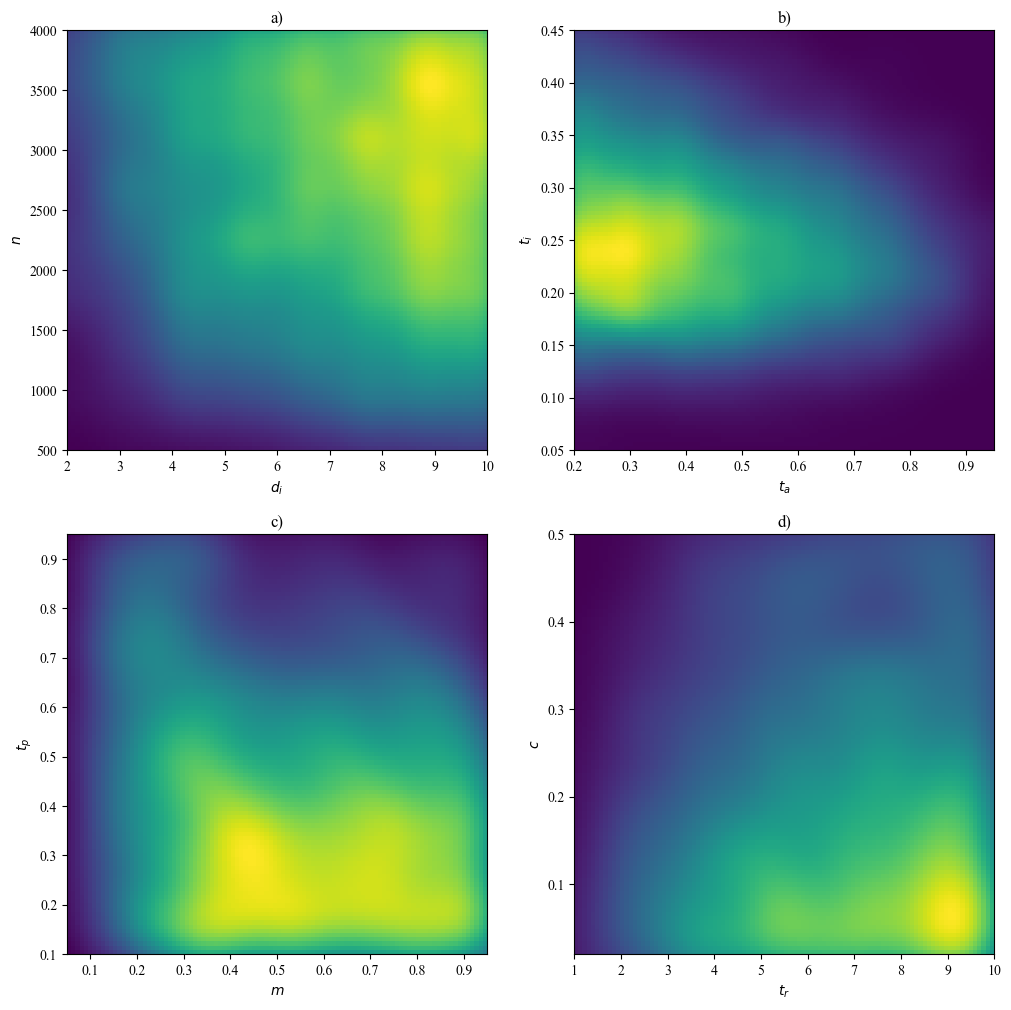

In [11]:
def make_countur(df, x_name, y_name, n, ax, title):
    x = df[x_name]
    y = df[y_name]
    k = kde.gaussian_kde([x, y])
    xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    # crea una heatmap con imshow 
    extent = [x.min(), x.max(), y.min(), y.max()]
    ax.imshow(zi.reshape(yi.shape), extent=extent, origin='lower', cmap='viridis', aspect='equal')

    ax.set_aspect((extent[1] - extent[0]) / (extent[3] - extent[2]))

    ax.set_xlabel(pars_rename[pars.index(x_name)])
    ax.set_ylabel(pars_rename[pars.index(y_name)])
    ax.set_title(title)

    return ax

pars_rename = [dict_variables[p] for p in pars]
fig, ax = plt.subplots(2,2, figsize=(12,12))
make_countur(df_inf, 'contagious_duration', 'num_agents', 10, ax[0,0], 'a)')
make_countur(df_inf, 'threshold', 'contagious_threshold', 10, ax[0,1], 'b)')
make_countur(df_inf, 'people_memory_weight', 'contagious_thresholdNotPresent', 10, ax[1,0], 'c)')
make_countur(df_inf, 'SIR_AgentsRecoveryTime', 'contagiousness', 10, ax[1,1], 'd)')
plt.show()
